## **Disclaimer**

_This presentation is not going to be a full-dive-into lecture on Machine Learning (ML) but a mere scratch of its surface. It was conceived with a simple purpose of puzzling and awakening your interest to the field of ML and its application in Particle Physics by providing an illustrative example from my own research._

_Although you will find some links here for further reading, still, for more information on what ML is and how to use it, please refer to proper literature, Wikipedia, YouTube, Coursera, Google, me or whichever way of learning you prefer._


#### **Gates into an ML world (to name a few)**:

* [HEP Community White Paper](https://arxiv.org/abs/1807.02876) - status overview of ML in HEP: what should be done, why and how

* [IML @LHC](https://iml.web.cern.ch) - community of data scientists at LHC. They do open meeting each month!

* [Summer School on ML in HEP by HSExYandex](https://indico.cern.ch/event/687473/)

* [MIPTxYandex specialisation on Coursera](https://www.coursera.org/specializations/machine-learning-data-analysis) - A MUST. Free certificate for MIPT students (just send an email to mooc@phystech.edu), free enrollment for everyone

* [Data Mining in Action](https://vk.com/data_mining_in_action) - ML for those who never known of it before. They've just started this semester classes so follow their github for lecture notes, seminars and even homeworks - it's all very fundamental and detailed. Highly recommended.

* [Deep Learning course book](http://www.deeplearningbook.org/) - a really nice one on ML and DL (and it's free!)

* [DL course for HSE students](https://github.com/yandexdataschool/Practical_DL) - links, tutorials, lectures on neural networks - it's all there starting from basics

* [LOTS OF LINKS](https://github.com/demidovakatya/vvedenie-mashinnoe-obuchenie) - actually I could've put here just this one

* [CNN from Stanford](http://cs231n.stanford.edu/) - a NN basics easily explained

* and way more in the Internet (just google it in English)

### **Software intro**

There are basically two ways of doing ML that I am aware of. If you have the data stored in root files you can proceed with using:

* [TMVA](http://tmva.sourceforge.net/)
* Python 

The first one is essentially ML libraries initially developed in python or elsewhere and brought to ROOT/C++ framework. In my humble opinion, it ~~sucks~~ doesn't have that functionality, design and flexibility with being slowly developing and lazily maintained - but for sure is a necessary thing to promote the variety of tools available. And you don't have to bother yourself with transforming the data (ROOT files) to a proper python format and can continue your analysis without leaving your cozy ROOT home.

The second way of doing is presented here and is build around [sklearn](http://scikit-learn.org/stable/) python library with the whole code written in [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/) - a fancy framework integrating elements of presentation and code altogether. Of course, you should now abandon ROOT, TWhatever classes and their methods and start doing things in an almost pure data scientist way - which is quite cool, I must say!

And what is really nice that there has already been developed a bridge between these two frameworks allowing for data transfer from ROOT into python formats and back. Here we will be using [root_numpy](http://scikit-hep.org/root_numpy/) library.

In [1]:
# import relevant libraries

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import ROOT
from ROOT import RooFit as RF
import root_numpy as rnp
from root_pandas import read_root

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

from IPython.display import Image        

from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn import linear_model, metrics, tree, ensemble
from sklearn.preprocessing import scale, StandardScaler, PolynomialFeatures
from sklearn import utils
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel, RFE
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, classification_report, matthews_corrcoef

import xgboost as xgb

%pylab inline  

Welcome to JupyROOT 6.14/04
Populating the interactive namespace from numpy and matplotlib


### **Introduction**

In this notebook we will look at one of the many applications of ML tools in the field of particle physics. Particularly, the goal is to solve a classic **binary classification problem** - separate signal from background in the most "efficient" way in the context of a $\text{B}_\text{s}^{0} \rightarrow \psi(2S) \phi$ decay study, where $\psi(2S) \rightarrow J/\psi \pi^{+} \pi^{-}$, $J/\psi \rightarrow \mu^{+} \mu^{-}$, $\phi \rightarrow K^{+} K^{-}$

Sometimes your data is not that trivial and the optimal decision boundary can not be constructed with just rectangular cuts of a phase space (old-fashioned **cut-based** way of doing analysis in HEP). Below is a simple example of such a situation: (plot is taken from [here](https://arxiv.org/abs/1505.07818) and in fact has a way deeper meaning)

That is exactly where **Machine Learning** (or Multivariate Analysis, **MVA** as they call it in HEP) comes into play. These algorithms are capable of capturing nonlinearities in your data thus constructing an optimal decision boundary. Having more flexibility allows them to adjust perfectly to your data (which might of course lead to **overfitting**, but about that latter) and moreover to capture general features and trends in your data.

<img src="pics/DANN.png" alt="drawing" width="900"/>

### **Illustrative plots**

In this work we will be using the 2012 data of pp collisions collected with the CMS experiment @LHC at $\sqrt{s}=8$ TeV

![](pics/psi_plot.png)

### **Variables and files to open**

In [2]:
variables = ( [

# Intermediate particle's pt and eta
    
 'mu_1_pt',  'mu_1_eta',
 'mu_2_pt',  'mu_2_eta',
    
 'K1_pt',  'K1_eta',
 'K2_pt',  'K2_eta',   

 'PI1_pt',  'PI1_eta',
 'PI2_pt',  'PI2_eta',   
  
 'JP_pt',   'JP_eta',
 'psi_pt',   'psi_eta',
 'phi_pt', 'phi_eta',
    
 'BU_pt_Cjp', 'BU_eta_Cjp', 

    
 'BU_pvcos2_Cjp', # 2D cosine of a Bs pointing angle
 'BU_vtxprob_Cjp', # p-value of a vtx kinematic fit under the chi^2 null hypothesis (aka vertex probability)
 'BU_pvdistsignif2_Cjp', # flight distance significance of a Bs meson relative to the primary vertex
    
 'PV_bestBang_RF_CL', # PV vertex probability
    
 'PIPI_mass_Cjp', 'psi_mass_Cjp', 'PHI_mass_Cjp', 'BU_mass_Cjp'] ) # masses

dR_vars = ['dR_mu1', 'dR_mu2', 'dR_pi1', 'dR_pi2', 'dR_K1', 'dR_K2']   # delta R variables for MC matching

MC = read_root('BsToPsiPhi_Smatch_v1_min_with_more_psi.root', columns = variables + dR_vars) # psi
data = read_root('new_2_with_more_psi.root', columns = variables)

### **Print data**

Let's have a look at what happened to our root file. It is a **pandas dataframe** now! (think of a simple table with events being rows and variables from TTree branches being columns)

In [3]:
data.head()

,PI2_pt,BU_vtxprob_Cjp,JP_pt,psi_pt,mu_2_eta,mu_2_pt,K1_eta,BU_eta_Cjp,BU_mass_Cjp,PI2_eta,...,PHI_mass_Cjp,PI1_pt,BU_pvdistsignif2_Cjp,BU_pvcos2_Cjp,K2_pt,BU_pt_Cjp,PI1_eta,phi_eta,mu_1_eta,mu_1_pt
0,0.600718,0.120611,12.855789,15.220870,-0.259383,6.079861,-0.572725,-0.499257,5.374444,-0.318851,...,1.009506,1.920597,14.472040,0.999371,0.792328,16.839408,-0.378099,-0.507569,-0.725867,6.784686
1,3.819208,0.866066,20.152593,31.028665,-0.279723,15.648944,-0.420843,-0.279104,5.445889,-0.257914,...,1.024647,7.088191,62.282520,0.999988,1.425886,34.306646,-0.268528,-0.367836,-0.233070,4.707489
2,1.093392,0.151426,14.728140,20.594132,0.750872,7.622695,1.012913,0.955262,5.506572,0.726417,...,1.044740,4.841542,11.982181,0.999817,2.823766,27.948860,0.835529,1.044036,1.151403,7.219025
3,0.954779,0.169773,14.747077,18.434179,0.750872,7.622695,1.012913,0.991760,5.182262,0.879466,...,1.044535,2.791276,9.954757,0.999998,2.823766,25.793126,1.029989,1.043966,1.151403,7.219025
4,0.954779,0.213535,14.746788,16.728699,0.750872,7.622695,1.012913,0.976365,5.195252,0.879466,...,1.044476,1.093392,10.067261,0.999994,2.823766,24.085764,0.726417,1.044019,1.151403,7.219025


### **Building sig and bkgr**

Of course we could've used MC to model the signal and data sidebands to model background and then train models on their combined data set. That would be a well-known example of a **binary classification** problem in a **supervised case**. But here for the sake of curiosity we will do it in a (sort of) **unsupervised** way (inspired by [this paper](https://arxiv.org/pdf/1805.02664.pdf)) - we do a binary classification with one class (labeled as "1") consisting of events from a *signal region* on data and the other class ("0") being the events from a *sideband region*. Of course, we _a priori_ know that there are background events in the signal region and and possibly signal events in the background region. But that is exactly the point!

Oh boy, that's fully data-driven now! 

But let us first examine the proper way and than if we have time come back to that weird experiment.

In [4]:
prob_cut = 1.1 # bad cut you shouldn't normally apply, useful to control the signal fraction in the signal region

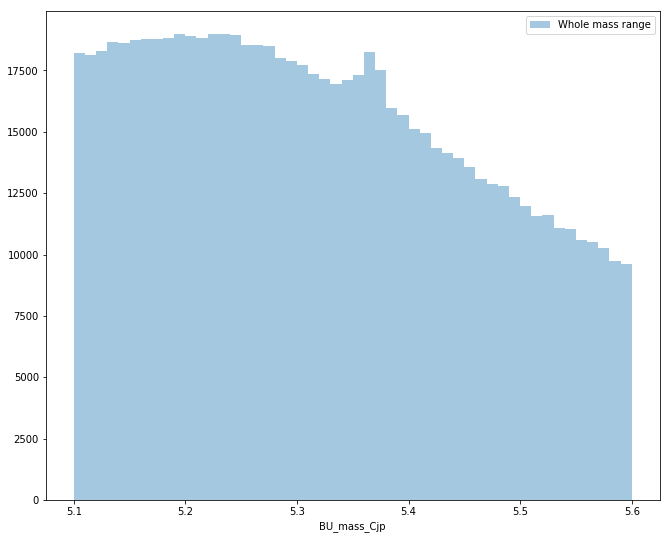

In [5]:
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.distplot(data[data['BU_vtxprob_Cjp'] < prob_cut]['BU_mass_Cjp'], label='Whole mass range', kde=False)
pylab.legend(loc='upper right')

In [6]:
#### ----- This we would do in the first example case

matching_mask = (MC['dR_mu1'] < 0.01) & (MC['dR_mu2'] < 0.01) & (MC['dR_pi1'] < 0.01) & (MC['dR_pi2'] < 0.01 )& (MC['dR_K1'] < 0.01) & (MC['dR_K2'] < 0.01) 
signal = MC[matching_mask]
bkgr = data[data['BU_mass_Cjp'].between(5.45, 5.55) | data['BU_mass_Cjp'].between(5.1, 5.25)] # sidebands

#### ----- This is for a conventional train-on-MC way

# signal = data[data['BU_mass_Cjp'].between(5.3, 5.47)] # our signal region
# bkgr = data[data['BU_mass_Cjp'].between(5.2, 5.3) | data['BU_mass_Cjp'].between(5.47, 5.55)] # sidebands
# dR_vars = []

In [7]:
signal = signal[signal['BU_vtxprob_Cjp'] < prob_cut]
bkgr = bkgr[bkgr['BU_vtxprob_Cjp'] < prob_cut]

#### **Plot signal region**

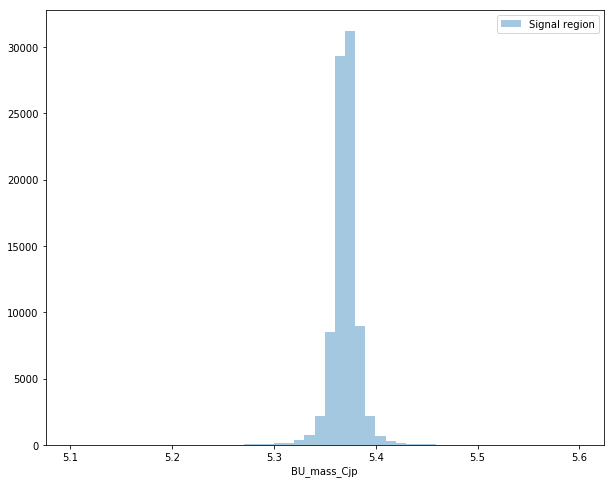

In [8]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.distplot(signal['BU_mass_Cjp'], label='Signal region', kde=False)
pylab.legend(loc='upper right')

#### **Plot bkgr region**

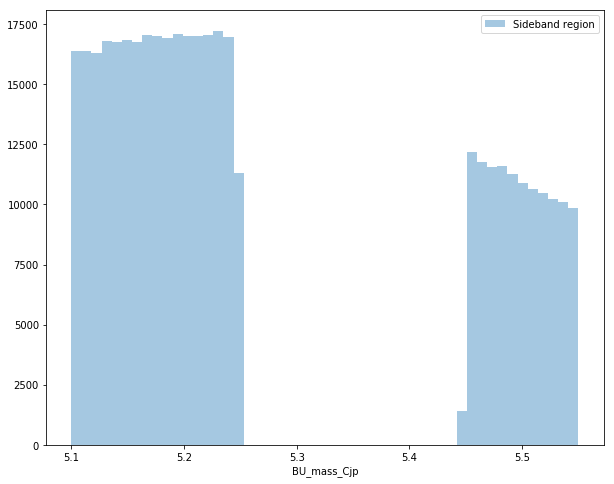

In [9]:
f, ax = plt.subplots(figsize=(10, 8))
sns.distplot(bkgr['BU_mass_Cjp'], label='Sideband region', kde=False)
pylab.legend(loc='upper right')

### **Define final dataframe for training**

Remove variable from the dataframe used for regions definition (total invariant mass) together with dR variables (not used)


In [10]:
drop_mass_vars = ['BU_mass_Cjp']

signal = signal.drop(dR_vars + drop_mass_vars, axis=1, inplace=False)
bkgr = bkgr.drop(drop_mass_vars, axis=1, inplace=False)

**Shuffle** (in general be careful with that, e.g. than having time-dependent analysis), balance by **undersampling** and make **target labels**. There are better ways of dealing with **unbalanced data**, e.g. oversampling or some complicated statistical staff, but in our case we have enough data to train a "good" model (explained below). Also some algorithms might be sensitive to the label definition ((0,1) vs (-1,1)) - you better check that!

Also hereafter we use **random_state** to be able to reproduce the same result afterwards.

In [11]:
min_shape = min(bkgr.shape[0], signal.shape[0])
# min_shape = 20000

bkgr = utils.shuffle(bkgr, random_state=123)[:min_shape] 
signal = utils.shuffle(signal, random_state=123)[:min_shape] 

### make target labels and append sig with bkgr
bkgr['target'] = [0]*bkgr.shape[0]
signal['target'] = [1]*signal.shape[0]
df = bkgr.append(signal, sort=True)


print('Sig/bkgr shapes:', signal.shape, bkgr.shape)
print('Dataframe shape:', df.shape)

Sig/bkgr shapes: (85465, 28) (85465, 28)
Dataframe shape: (170930, 28)


<img src="pics/nan.jpg" alt="drawing" width="500"/>

 ### **Drop nan, shuffle and split into X (features) and y(targets)**

Yes, there might be some **NaNs** in your pretty data. These are basically infinities and that kind of incalculatable things on which you definitely don't want to train your model and perform further inference. Moreover, this is a part of a very import **data preprocessing** stage.

In [12]:
print ('Nan indices:\n ', np.argwhere(np.isnan(df.values)), '\n', sum(np.isnan(df.values)))
df = df.dropna(inplace=False) 

df = utils.shuffle(df, random_state=123)
X = df.iloc[:, :-1]
y = df['target']

Nan indices:
  [[  8281      3]
 [ 12673      3]
 [ 16008      3]
 [ 20062      3]
 [ 23571      3]
 [ 25266      3]
 [ 31818      3]
 [ 37647      3]
 [ 47211      3]
 [ 47709      3]
 [ 51484      3]
 [ 52059      3]
 [ 60619      3]
 [ 69496      3]
 [ 72737      3]
 [ 90912      3]
 [ 92353      3]
 [ 99278      3]
 [ 99398      3]
 [101100      3]
 [107315      3]
 [110996      3]
 [116825      3]
 [117738      3]
 [119252      3]
 [120072      3]
 [120777     17]
 [121428      3]
 [124024      3]
 [126528      3]
 [127279      3]
 [127442      3]
 [129038      3]
 [129897      3]
 [130608      3]
 [138611      3]
 [139245      3]
 [139811      3]
 [142228      3]
 [142462      3]
 [148522      3]
 [150367      3]
 [152735      3]
 [152996      3]
 [155230      3]
 [155635      3]
 [156070      3]
 [157610      3]
 [157842      3]
 [163649      3]
 [164515      3]
 [166159      3]
 [169660      3]
 [169815      3]
 [169863      3]] 
 55


In [13]:
print(f'NaNs in features:\n{df.columns[3]}, {df.columns[17]}')

NaNs in features:
BU_pvdistsignif2_Cjp, PV_bestBang_RF_CL


### **Train / Test split**
##### (with optional Oversampling and Poly features)

This is a whole story involving such a thing as **overfitting**. We don't want our model to adapt itself absoulutely to data (as what would happen if we were to fit a linear distributed data with a 100 degree polynomial) but to learn its general features. One of the ways to verify whether we are overtrained is to split the data into a **train set** and a **test set**, train the model on the train data and then check the model quality on the test set.

In [14]:
# ros = RandomOverSampler(random_state=123)
# X_resampled, y_resampled = ros.fit_sample(X, y)

# poly = PolynomialFeatures(2)
# X_poly = poly.fit_transform(X)
# predict_poly = poly.fit_transform(predict.drop(mass_vars, axis=1, inplace=False))
# X_resampled, y_resampled = X_poly.copy(), y.copy()

# (X_train, X_test, y_train, y_test) = train_test_split(X_resampled, y_resampled,
#                                      test_size=0.2, 
#                                      random_state=123)

In [15]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y,
                                     test_size=0.2, 
                                     random_state=123, stratify=y)

Lookin at the balance again

In [16]:
y_train.value_counts()

0    68360
1    68340
Name: target, dtype: int64

##### Standart Scaling (optional, a must for metric sensitive models)

In [17]:
# scaler = StandardScaler().fit(X)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

### **Predict data**

Cutting out mass windows and dropping nans

In [18]:
mass_mask_for_prediction = np.array([True] * data.shape[0])
# sig_window = {'BU_mass_Cjp': [5.3669 - 0.2, 5.3669 + 0.2], 'psi_mass_Cjp': [3.686 - 0.06, 3.686 + 0.06], 'PHI_mass_Cjp': [1.0195 - 0.030, 1.0195 + 0.030]}
sig_window = {'BU_mass_Cjp': [5.3669 - 0.2, 5.3669 + 0.2], 'BU_vtxprob_Cjp': [-1., prob_cut]}

### compose a mass window mask
for key, value in sig_window.items():
    mass_mask_for_prediction &= (data[key] > value[0]) & (data[key] < value[1]) 
    
predict = data[mass_mask_for_prediction]

In [19]:
print ('Nan indices:\n ', np.argwhere(np.isnan(predict.values)), '\n', sum(np.isnan(predict.values)))
predict = predict.dropna(inplace=False)

Nan indices:
  [[  1488     20]
 [  2392     20]
 [  5885     20]
 [  7257     20]
 [  7983     20]
 [  9163     20]
 [ 11528     20]
 [ 12458     20]
 [ 12962     20]
 [ 16322     20]
 [ 18675     20]
 [ 20149     20]
 [ 23264     20]
 [ 23685     20]
 [ 36553     20]
 [ 36554     20]
 [ 36558     20]
 [ 40293     20]
 [ 42615     20]
 [ 42741     20]
 [ 46262     20]
 [ 46267     20]
 [ 46275     20]
 [ 46277     20]
 [ 46303     20]
 [ 46718     20]
 [ 49665     20]
 [ 51115     20]
 [ 58089     20]
 [ 63430     20]
 [ 64914     20]
 [ 65026     20]
 [ 69574     20]
 [ 82883     20]
 [ 83081     20]
 [ 87988     20]
 [ 88427     20]
 [ 89323     20]
 [ 97551     20]
 [ 97552     20]
 [ 98949     20]
 [103823     20]
 [104795     20]
 [105559     20]
 [106149     20]
 [108742     20]
 [111167     20]
 [115874     20]
 [117117     20]
 [119497     20]
 [128368     20]
 [128897     20]
 [129480     20]
 [131029     20]
 [131030     20]
 [131032     20]
 [131769     20]
 [134101     20]

In [20]:
print(f'NaNs in features:\n{predict.columns[27]}')

NaNs in features:
mu_1_pt


### **Splitting into predict features (same as before) and predict targets (masses)**

Matching columns to train sample **is damn important**! (otherwise behavior is unpredictable)

In [21]:
predict_masses = predict[['psi_mass_Cjp', 'PHI_mass_Cjp', 'BU_mass_Cjp']]
predict_data = predict.drop(drop_mass_vars, axis=1, inplace=False)[X_train.columns] # here

# predict_data = StandardScaler().fit_transform(predict.drop(mass_vars, axis=1, inplace=False))

In [22]:
print(f'predict data shape: {predict_data.shape}')
print(f'train data shape: {X_train.shape}')
print(f'test data shape: {X_test.shape}')

predict data shape: (631457, 27)
train data shape: (136700, 27)
test data shape: (34175, 27)


### **Feature selection with Recursive Feature Elimination**

Features might and should be selected. There are several ways to do that (you can find some info [here](http://scikit-learn.org/stable/modules/feature_selection.html)). We will train a dedicated classifier which has a naturally implemented feature assessment - **logistic regression**

Logistic regression boils down to the following optoimisation problem:
$$\min_{w, c} \; [L \equiv \frac{1}{2}w^T w + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1)]$$
where $w, c, y_i, X_i$ are the model weights, biases, targets and features respectively.

Firstly, we train it on the whole features set. Then we look for a feature with the smallest corresponding weight and remove it from the dataframe. Thus we proceed until we run out of features with the last feature being the most important one (and the first - the least)

But beware! There is no absolute here, just food for thought

In [173]:
%%time

logreg = linear_model.LogisticRegression(penalty='l2', fit_intercept=False, C=0.01, random_state=123, solver='saga', warm_start=True, n_jobs=-1)
rfe = RFE(estimator=logreg, n_features_to_select=1, step=1)
rfe.fit(X_train, y_train.replace(0, -1))
ranking = rfe.ranking_

/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was

CPU times: user 32.8 s, sys: 133 ms, total: 33 s
Wall time: 34.2 s


In [174]:
for i,var in enumerate(X.columns[np.argsort(ranking)]):
    print(i+1, var, '\n')

1 BU_vtxprob_Cjp 

2 PV_bestBang_RF_CL 

3 psi_mass_Cjp 

4 PIPI_mass_Cjp 

5 phi_pt 

6 K2_pt 

7 PI1_pt 

8 mu_2_pt 

9 mu_1_pt 

10 JP_pt 

11 K1_pt 

12 BU_pt_Cjp 

13 psi_pt 

14 BU_pvdistsignif2_Cjp 

15 BU_pvcos2_Cjp 

16 PI1_eta 

17 PI2_pt 

18 mu_1_eta 

19 mu_2_eta 

20 PHI_mass_Cjp 

21 PI2_eta 

22 K2_eta 

23 K1_eta 

24 BU_eta_Cjp 

25 JP_eta 

26 psi_eta 

27 phi_eta 



### **Bkgr histos**

Some plots for mass variables distributions for the background

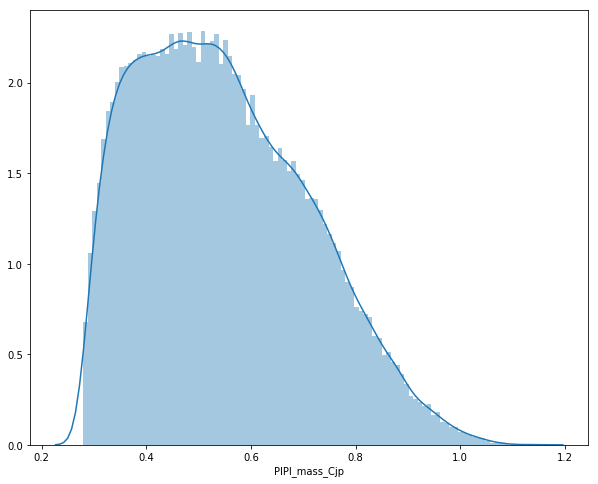

In [212]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.distplot(bkgr['PIPI_mass_Cjp'], bins=100)

(3.4, 4.3)

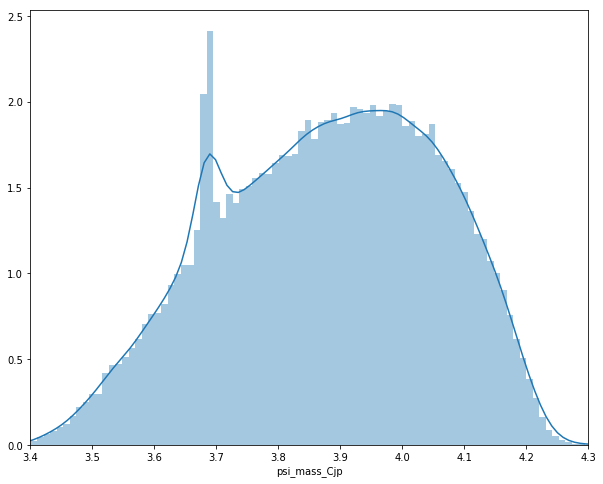

In [213]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.distplot(bkgr['psi_mass_Cjp'], bins=100)
ax.set_xlim(3.4, 4.3)

We see $\psi(2S)$ in the background sidebands!

(0.975, 1.075)

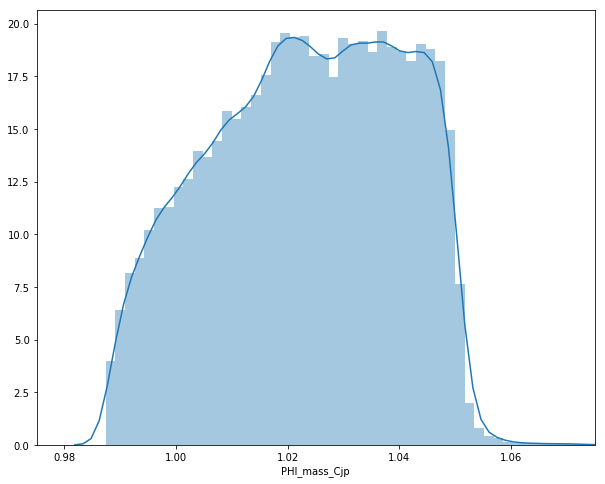

In [214]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.distplot(bkgr['PHI_mass_Cjp'], bins=100)
ax.set_xlim(0.975, 1.075)

And $\phi$! (if you don't apply that nasty cut on the vertex probability)

Wait a sec, but what are these guys doing here?

### **Pair plots and correlations**

Note: this is signal MC!

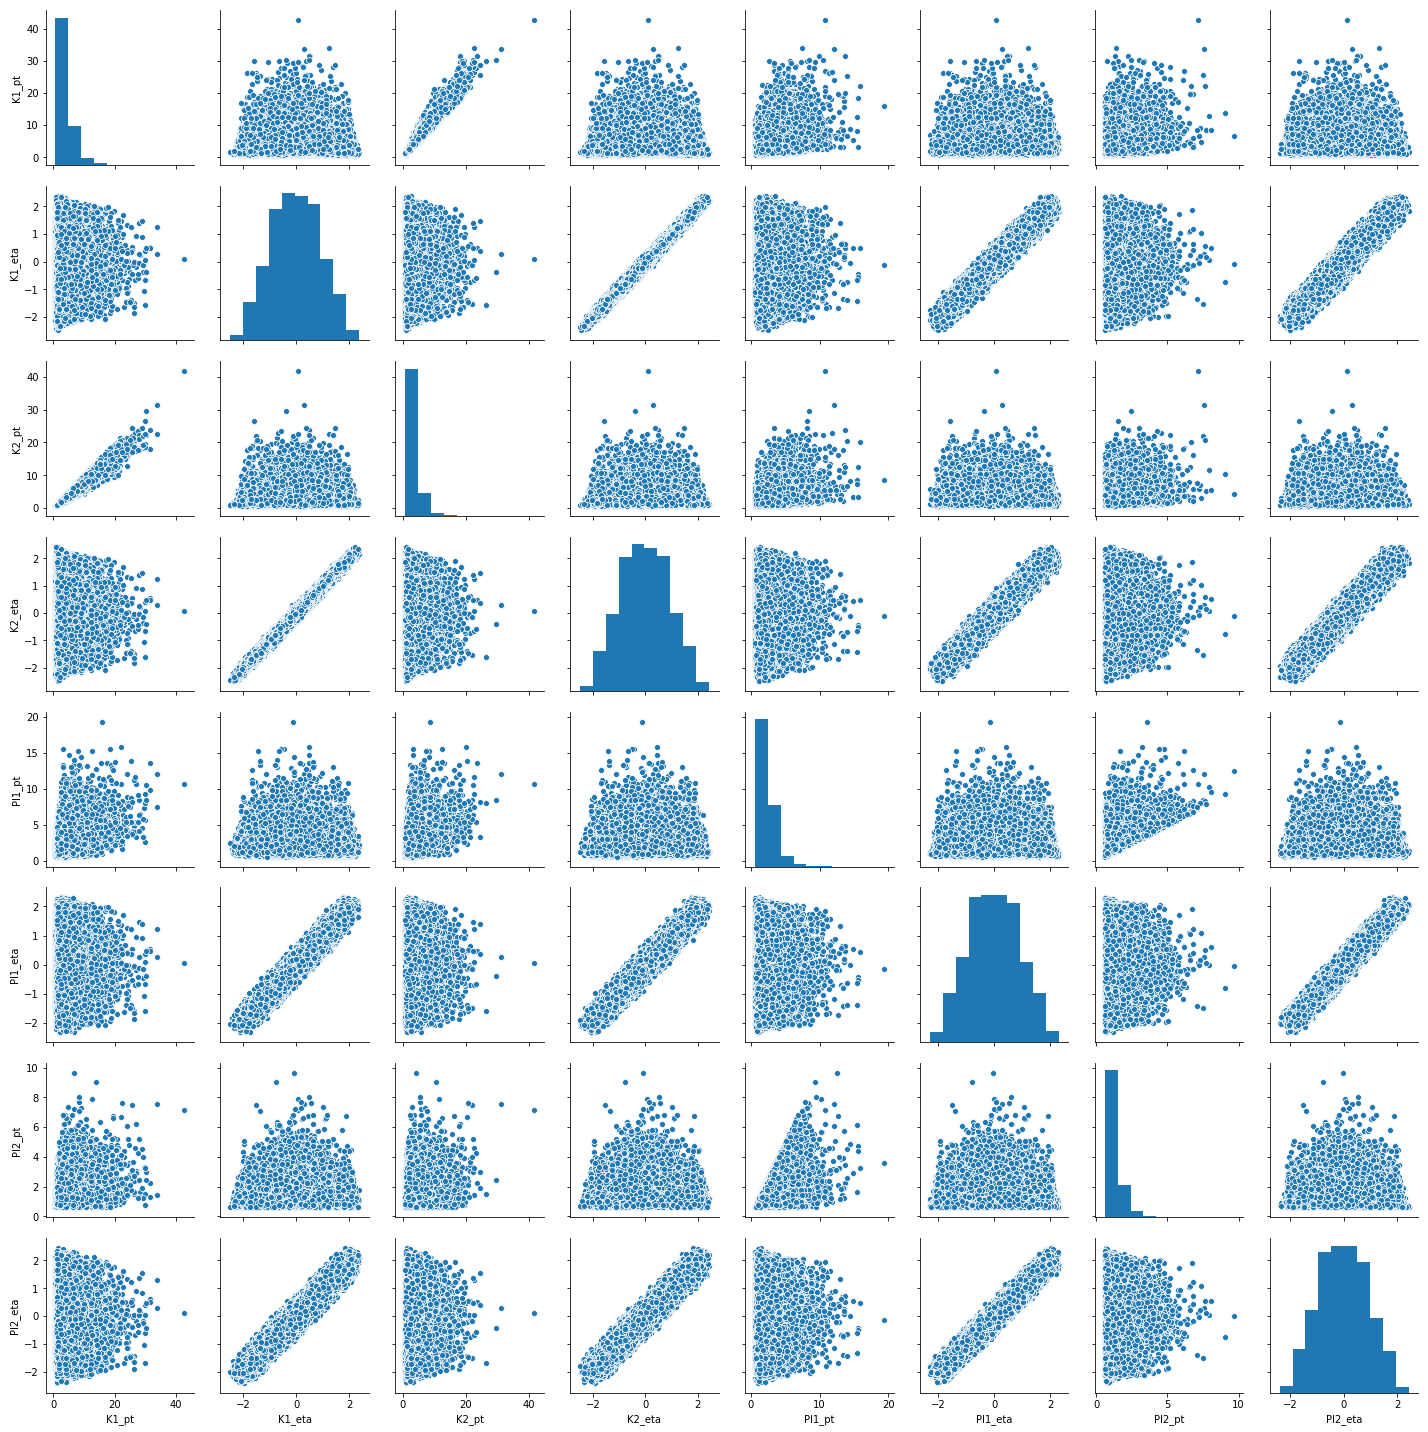

In [215]:
sns.pairplot(signal[['K1_pt', 'K1_eta',
'K2_pt', 'K2_eta', 'PI1_pt', 'PI1_eta',
'PI2_pt', 'PI2_eta']])
plt.show()

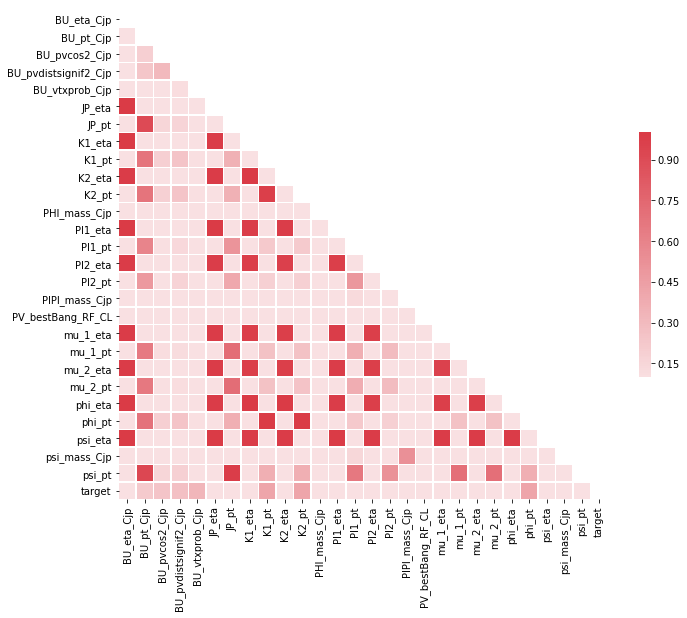

In [216]:
sig_corr = df[sorted(df.columns)].corr()
mask = np.zeros_like(sig_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(sig_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False, vmin=0.1)

# Try various classifiers

![](pics/classif_comp.png)

There are whole lotta classifiers available on the market [[link]](http://scikit-learn.org/stable/supervised_learning.html). Here we shall use three of the most famous ones (leaving neural networks aside) - **logistic regression, random forest** and **XGBoost**.

### **Logistic Regression**

Let's begin with a simple but widely used (mainly in industry) logistic regression. Hereafter we are gonna be using [**cross-validation**](http://scikit-learn.org/stable/modules/cross_validation.html) to define the best **hyperparameter** values - parameters of a model which can't be learned, e.g. a polynomial degree in the example of fitting your data with a poly function. Essentially, this is a splitting of your data into k parts (aka folds), training of your model on k-1 parts, testing it on the remaining part and then repeating the process k-1 more times. Once you've done that for a one point one the **hyperparameter grid** you repeat it for the other points (so-called **GridSearch**). After that you average the scores over all the folds separately for each point on the hyperparameter grid and than choose the best one according to the best score value.

Thus, you save your precious data from splitting into a potentially lots of test parts which would significantly reduce the size of the train set.

<img src="pics/CV.png" alt="drawing" width="700"/>

### **CV**

Note probing C-values on the **log scale!**

In [218]:
%%time
C_range = range(-3,3)
log_regressor_CV = linear_model.LogisticRegressionCV(penalty='l2', scoring='accuracy', Cs=[10**i for i in C_range], random_state = 123, cv=3, solver='saga', n_jobs=-1)
log_regressor_CV.fit(X_train, y_train)

/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was

CPU times: user 6min 53s, sys: 5min 5s, total: 11min 59s
Wall time: 5min 3s


/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [219]:
# print(np.median(prediction), log_regressor_CV.C_)
for _C, _score in zip(log_regressor_CV.Cs_, log_regressor_CV.scores_[1].mean(axis=0)):
    print(f'C = {_C}, mean accuracy = {_score:.3f}')

C = 0.001, mean accuracy = 0.781
C = 0.01, mean accuracy = 0.796
C = 0.1, mean accuracy = 0.804
C = 1.0, mean accuracy = 0.807
C = 10.0, mean accuracy = 0.811
C = 100.0, mean accuracy = 0.814


We reached the parameters border! Need to expand the range and redo CV.

### **Simple logreg**

In [23]:
%%time
log_regressor_CV = linear_model.LogisticRegression(penalty='l2', C=0.01, random_state = 123, solver='saga', n_jobs=-1)
log_regressor_CV.fit(X_train, y_train)

CPU times: user 11.3 s, sys: 51 ms, total: 11.4 s
Wall time: 11.5 s


/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Let's make a prediction then - **predict_proba** method gives the probability of a sample to belong to a class.

In [24]:
prediction_logreg = log_regressor_CV.predict_proba(predict_data)[:, 1]

And here goes **metrics**!

In [25]:
print(classification_report(y_test, log_regressor_CV.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.86      0.80     17090
           1       0.83      0.73      0.78     17085

   micro avg       0.79      0.79      0.79     34175
   macro avg       0.80      0.79      0.79     34175
weighted avg       0.80      0.79      0.79     34175



In [26]:
print(f'ROC AUC = {metrics.roc_auc_score(y_test, log_regressor_CV.predict(X_test))}')
print(f'log loss = {metrics.log_loss(y_test, log_regressor_CV.predict_proba(X_test))}')
print(f'Matthews correlation coefficient = {matthews_corrcoef(y_test, log_regressor_CV.predict(X_test)):.3f}')

ROC AUC = 0.7925584619497084
log loss = 0.46021807606150567
Matthews correlation coefficient = 0.590


### **(Almighty) XGBoost**

Further reading - [[link]](https://xgboost.readthedocs.io/en/latest/)

#### **Convert data into XGBoost format**

In [27]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dpredict = xgb.DMatrix(predict_data)

#### **Learning curve for number of trees**

In [83]:
ntrees = range(5, 51, 5)

xgb_scoring = []
for n_tree in ntrees :
    estimator = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=n_tree, min_child_weight=3)
    score = cross_validate(estimator, X_train[:20000], y_train[:20000], scoring = 'accuracy', cv = 3) 
    print(score)
    xgb_scoring.append(score)
# xgb_scoring = np.asmatrix(xgb_scoring)
test_scores = []
for row in xgb_scoring:
    test_scores.append(row['test_score'].mean())

{'fit_time': array([0.20608115, 0.16408443, 0.16118932]), 'score_time': array([0.00450397, 0.00390649, 0.00784969]), 'test_score': array([0.95830208, 0.95680216, 0.95649565]), 'train_score': array([0.95904898, 0.96047401, 0.96032698])}
{'fit_time': array([0.293751  , 0.2838161 , 0.28608775]), 'score_time': array([0.00427413, 0.00910711, 0.00424671]), 'test_score': array([0.96055197, 0.95815209, 0.95874587]), 'train_score': array([0.960174  , 0.96212405, 0.96227689])}
{'fit_time': array([0.42481232, 0.41037035, 0.40914059]), 'score_time': array([0.00469732, 0.00491929, 0.00470448]), 'test_score': array([0.96265187, 0.95920204, 0.96054605]), 'train_score': array([0.96152404, 0.9638491 , 0.96265187])}
{'fit_time': array([0.54339075, 0.53385639, 0.53580999]), 'score_time': array([0.00501299, 0.00518322, 0.00511432]), 'test_score': array([0.9640018 , 0.96085196, 0.96159616]), 'train_score': array([0.96197405, 0.96504913, 0.9640018 ])}
{'fit_time': array([0.66173935, 0.66003609, 0.67305088])

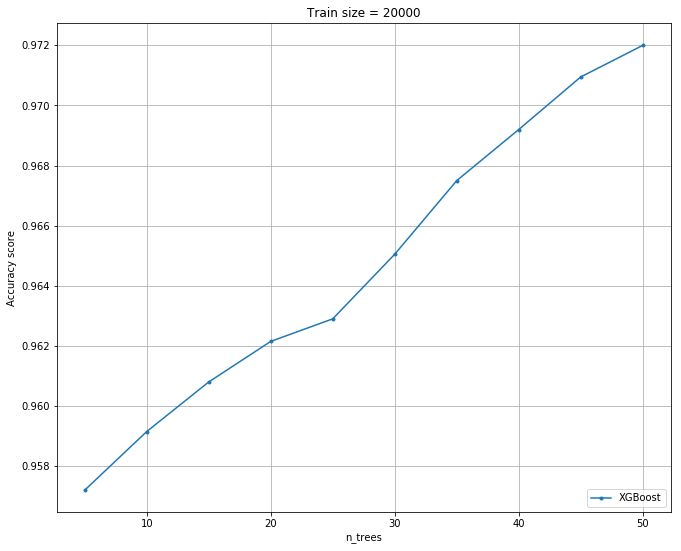

In [85]:
# pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.figure(figsize=(11, 9))
pylab.plot(ntrees, test_scores, marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('Accuracy score')
pylab.title('Train size = 20000')
pylab.legend(loc='lower right')

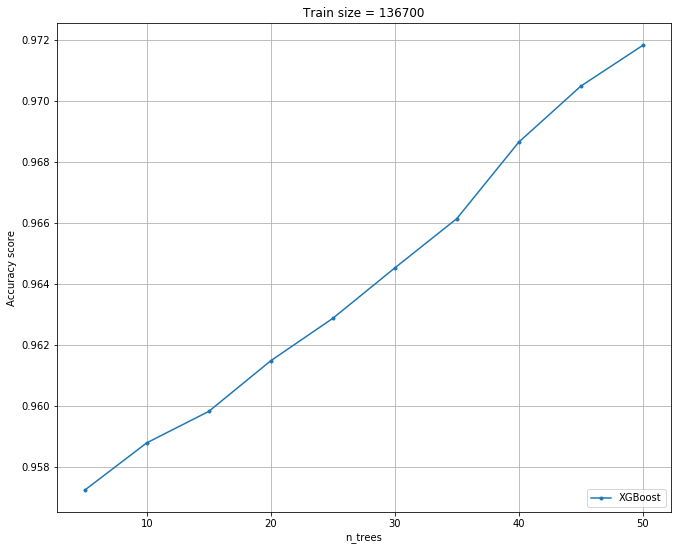

In [80]:
# pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.figure(figsize=(11, 9))
pylab.plot(ntrees, test_scores, marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('Accuracy score')
pylab.title('Train size = 136700')
pylab.legend(loc='lower right')

### **Learning curve for a train sample size**

In [86]:
xgb_classif = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=200, min_child_weight=3)
train_sizes, train_scores, test_scores = learning_curve(xgb_classif, X_train, y_train, 
                                                                     train_sizes=[0.1, 0.5, 0.8, 0.9], #      train_sizes=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5], 
                                                                     cv=3, scoring='accuracy')

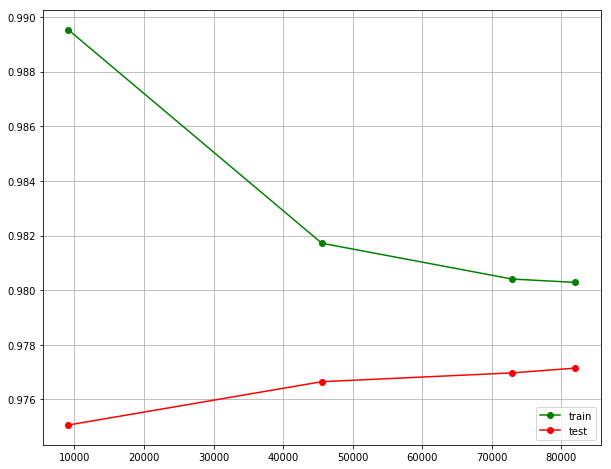

In [91]:
pylab.figure(figsize=(10, 8))
pylab.grid(True)
pylab.plot(train_sizes, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(train_sizes, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
# pylab.ylim((0.95, 1.0))
pylab.legend(loc='lower right')

<img src="pics/overfit.jpg" alt="drawing" width="400"/>

#### **Search hyperparameters on grid**

In [48]:
%%time
cv_params = {'max_depth': [8, 10, 12], 'min_child_weight': [8, 10, 12], 'learning_rate': [0.1, 0.2, 0.3], 'reg_lambda': [0.1], 'colsample_bytree': [1.], 'subsample': [1.]}

ind_params = {'n_estimators': 20, 'seed':0, 
             'objective': 'binary:logistic'}
 
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params),cv_params, 
                             scoring = 'accuracy', cv = 3, n_jobs = -1) 
optimized_GBM.fit(X_train, y_train)
print(optimized_GBM.best_params_)

{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 10, 'reg_lambda': 0.1, 'subsample': 1.0}
CPU times: user 38.6 s, sys: 1.21 s, total: 39.8 s
Wall time: 12min 23s


In [50]:
xgb_cv = pd.DataFrame(optimized_GBM.cv_results_)

/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/yaourt/anaconda3/lib/pyth

In [51]:
xgb_cv[['mean_test_score', 'param_max_depth', 'param_min_child_weight', 'param_learning_rate']]

,mean_test_score,param_max_depth,param_min_child_weight,param_learning_rate
0,0.614529,8,8,0.1
1,0.614572,8,10,0.1
2,0.613614,8,12,0.1
3,0.616678,10,8,0.1
4,0.615990,10,10,0.1
5,0.615395,10,12,0.1
6,0.615879,12,8,0.1
7,0.617077,12,10,0.1
8,0.615849,12,12,0.1
9,0.611687,8,8,0.2


In [52]:
optimized_GBM.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 10,
 'reg_lambda': 0.1,
 'subsample': 1.0}

#### **Final params**

In [28]:

_params = {'silent': 1, 'objective': 'binary:logistic', 'seed': 123, 
           'max_depth': 3, 'subsample': .8, 'colsample_bytree': .8,
           'learning_rate': 0.1,  'lambda': 0.1, 'gamma': 0.1
               }
_params['nthread'] = 4
_params['eval_metric'] = ['error']

num_round = 1000
evallist = [(dtest, 'eval')]

#### **Train & Predict**

Here we trace in real time the change of metric (specified above) on a validation set.

**Choice of learning rate is crucial!** 
Might not convert to wrong minimum or don't converge at all or it will take lots of time!

In [29]:
final_gb = xgb.train(params=_params, dtrain=dtrain, evals=evallist, early_stopping_rounds=10, num_boost_round=num_round)
prediction_xgb = final_gb.predict(dpredict, ntree_limit=final_gb.best_ntree_limit, validate_features=True)

[0]	eval-error:0.044623
Will train until eval-error hasn't improved in 10 rounds.
[1]	eval-error:0.043307
[2]	eval-error:0.043131
[3]	eval-error:0.043102
[4]	eval-error:0.042955
[5]	eval-error:0.041405
[6]	eval-error:0.042634
[7]	eval-error:0.042282
[8]	eval-error:0.041639
[9]	eval-error:0.041434
[10]	eval-error:0.041287
[11]	eval-error:0.041083
[12]	eval-error:0.041258
[13]	eval-error:0.040439
[14]	eval-error:0.040439
[15]	eval-error:0.040205
[16]	eval-error:0.039971
[17]	eval-error:0.039707
[18]	eval-error:0.039473
[19]	eval-error:0.039093
[20]	eval-error:0.038742
[21]	eval-error:0.038361
[22]	eval-error:0.038391
[23]	eval-error:0.037659
[24]	eval-error:0.037484
[25]	eval-error:0.037279
[26]	eval-error:0.036869
[27]	eval-error:0.036284
[28]	eval-error:0.03605
[29]	eval-error:0.035582
[30]	eval-error:0.034792
[31]	eval-error:0.034733
[32]	eval-error:0.034792
[33]	eval-error:0.034323
[34]	eval-error:0.034119
[35]	eval-error:0.033475
[36]	eval-error:0.033211
[37]	eval-error:0.032772
[38

#### **Feature importance**

XGBoost has a nice functionality of assessing a feature importance in a quite natural way based on the training process - intuitively, depending on the number of splits which were caused by the feature.

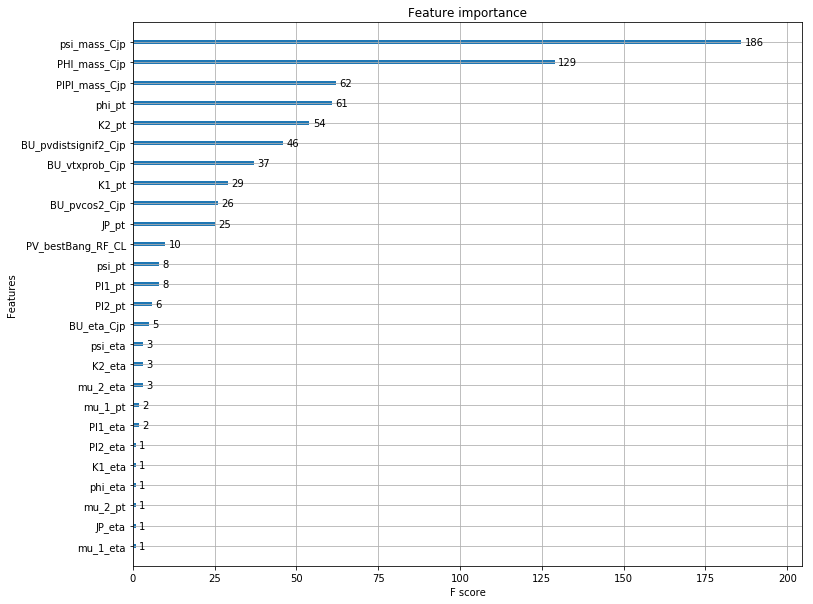

In [30]:
score_dict = final_gb.get_score()

fig, ax = plt.subplots(figsize=(12, 10))
xgb.plot_importance(final_gb, ax=ax)

#### **Metrics**

They are cut-sensitive!

In [31]:
print(classification_report(y_test, final_gb.predict(dtest) > 0.5))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     17090
           1       0.96      0.99      0.98     17085

   micro avg       0.98      0.98      0.98     34175
   macro avg       0.98      0.98      0.98     34175
weighted avg       0.98      0.98      0.98     34175



In [32]:
print(f'ROC AUC = {metrics.roc_auc_score(y_test, final_gb.predict(dtest))}')
print(f'log loss = {metrics.log_loss(y_test, final_gb.predict(dtest))}')
print(f'Matthews correlation coefficient = {matthews_corrcoef(y_test, final_gb.predict(dtest) > 0.5):.3f}')

ROC AUC = 0.996042506292754
log loss = 0.07149894292037556
Matthews correlation coefficient = 0.950


If you tried w/o undersampling you could get AUC=0.9968!

### **Random Forest**

<img src="pics/RF.png" alt="drawing" width="500"/>

#### **CV**

In [22]:
forest_classif = ensemble.RandomForestClassifier(max_features='sqrt', random_state=1, max_depth=None, 
                                                 bootstrap=True, oob_score=True,
                                                 n_jobs=-1)

cv_params = {'n_estimators': [100, 300, 500]}

forest_classif_CV = GridSearchCV(forest_classif,cv_params, 
                             scoring = 'accuracy', cv = 3, n_jobs = 1) 
forest_classif_CV.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=True, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'n_estimators': [100, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [23]:
RF_cv = pd.DataFrame(forest_classif_CV.cv_results_)

/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/yaourt/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/yaourt/anaconda3/lib/pyth

In [24]:
RF_cv[['param_n_estimators', 'mean_test_score']]

,param_n_estimators,mean_test_score
0,100,0.543438
1,300,0.548415
2,500,0.550065


#### **Plain RF**

In [33]:
%%time
forest_classif = ensemble.RandomForestClassifier(max_features='sqrt',n_estimators=100, random_state=1, max_depth=None, 
                                                 bootstrap=True, oob_score=True,
                                                 n_jobs=-1)
### train on all the data
forest_classif.fit(X, y)
prediction_RF = forest_classif.predict_proba(predict_data)[:, 1]

CPU times: user 4min, sys: 5.36 s, total: 4min 5s
Wall time: 1min 4s


RF has a fancy **out-of-bag** feature - after each iteration (i.e. training of another tree) there are samples left which weren't seen by a classifier. That means we have a nice way to save our precious data from splitting into train/test and train the forest on the whole data with validating on the out-of-bag set.

In [34]:
print(f'out-of-bag accuracy = {forest_classif.oob_score_}')
print(f'ROC AUC = {metrics.roc_auc_score(y_test, forest_classif.predict(X_test))}')
print('\nHow come???')

out-of-bag accuracy = 0.9754732991953182
ROC AUC = 1.0

How come???


In [44]:
forest_classif.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

#### **Metrics**

In [45]:
print(classification_report(y_test, forest_classif.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5023
           1       0.96      0.98      0.97      4974

   micro avg       0.97      0.97      0.97      9997
   macro avg       0.97      0.97      0.97      9997
weighted avg       0.97      0.97      0.97      9997



In [46]:
print(f'ROC AUC = {metrics.roc_auc_score(y_test, forest_classif.predict_proba(X_test)[:, 1])}')
print(f'log loss = {metrics.log_loss(y_test, forest_classif.predict(X_test))}')
print(f'Matthews correlation coefficient = {matthews_corrcoef(y_test, forest_classif.predict(X_test)):.3f}')

ROC AUC = 0.9941824102894277
log loss = 0.9155668771612548
Matthews correlation coefficient = 0.947


#### **Feature importance**

mind the correlations!

Feature ranking:
1. psi_mass_Cjp (0.478338)
2. PIPI_mass_Cjp (0.128835)
3. PHI_mass_Cjp (0.072641)
4. phi_pt (0.066905)
5. K2_pt (0.060432)
6. K1_pt (0.044633)
7. BU_pvdistsignif2_Cjp (0.036063)
8. BU_vtxprob_Cjp (0.024029)
9. BU_pvcos2_Cjp (0.011719)
10. PI1_pt (0.010197)
11. BU_pt_Cjp (0.006932)
12. JP_pt (0.006525)
13. PI2_pt (0.006399)
14. psi_pt (0.005568)
15. PV_bestBang_RF_CL (0.004868)
16. mu_1_pt (0.004392)
17. mu_2_pt (0.004291)
18. PI2_eta (0.002919)
19. PI1_eta (0.002866)
20. mu_2_eta (0.002832)
21. mu_1_eta (0.002777)
22. K1_eta (0.002737)
23. K2_eta (0.002690)
24. phi_eta (0.002663)
25. psi_eta (0.002625)
26. JP_eta (0.002606)
27. BU_eta_Cjp (0.002518)


(-1, 27)

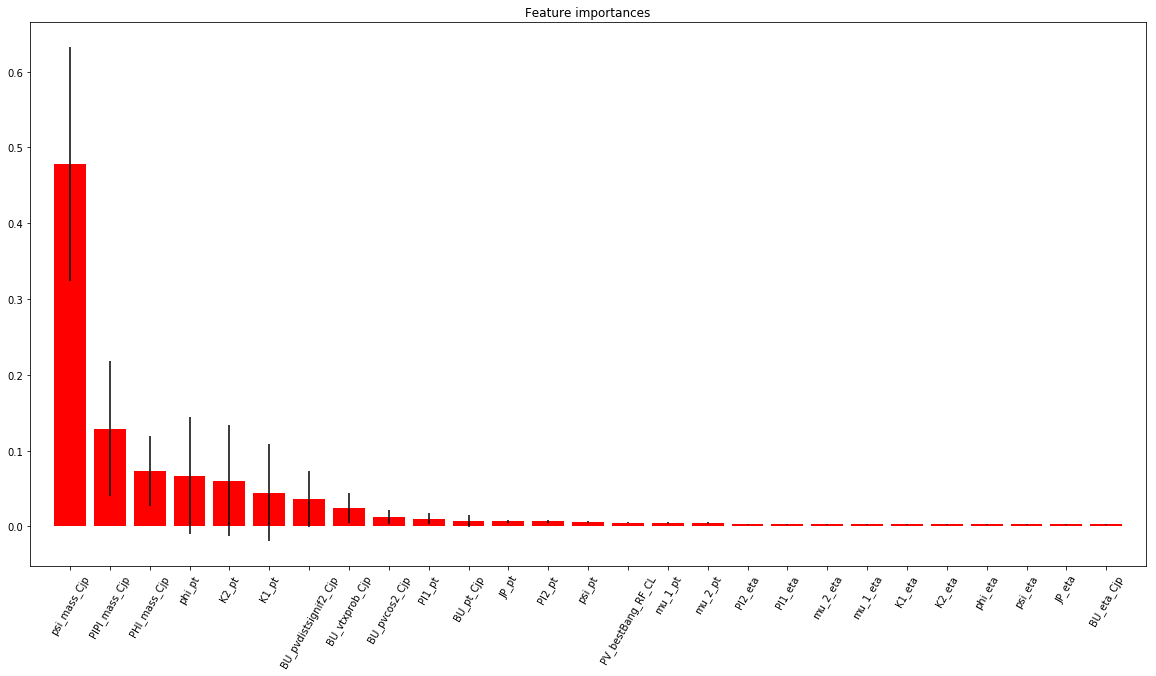

In [35]:
importances = forest_classif.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_classif.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for i, index in enumerate(indices):
    print("%d. %s (%f)" % (i+1, X.columns[index], importances[index]))

# Plot the feature importances of the forest
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=60)
plt.xlim([-1, X.shape[1]])

## Final inference

#### **Classifiers' output (essentially probability of belonging to a "1" class)**

Here is in fact a good example why we should use **Kernel Density Estimation** (KDE) alonside the conventional histograms:

* Why do we have spikes for the RF distribution?

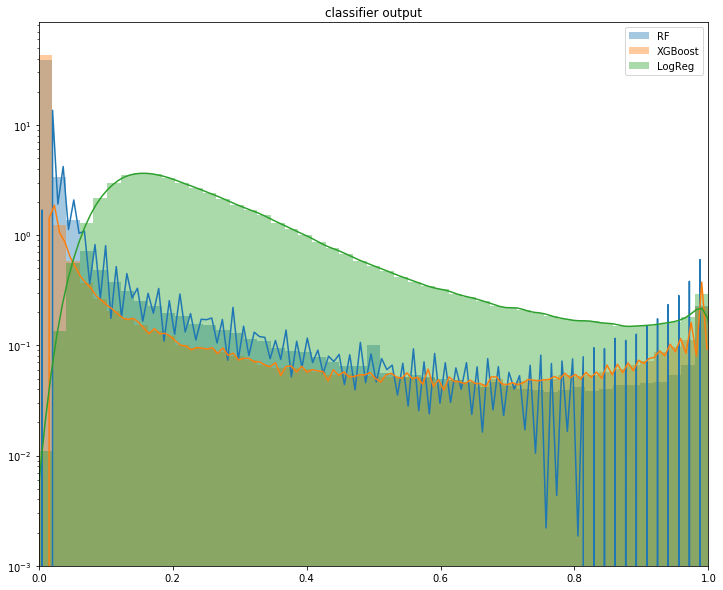

In [36]:
fig, ax = plt.subplots(figsize=(12,10))
outputs = {'RF': prediction_RF, 'XGBoost': prediction_xgb, 'LogReg': prediction_logreg}
# outputs = {'XGBoost': prediction_xgb}

for label, proba in outputs.items():
    sns.distplot(proba, ax=ax, bins=np.linspace(0., 1., num=50,  endpoint=True), label = label, kde=True, hist=True, norm_hist=True)
ax.set_xlim(0., 1.)
ax.set_title('classifier output')

plt.legend()
plt.yscale('log')
plt.ylim(10**(-3))

plt.show()

#### **Select masses according to classifier pradiction cut**

With cut > 0.8 survived 8066 out of 631457 for RF
With cut > 0.8 survived 11240 out of 631457 for XGBoost
With cut > 0.8 survived 21967 out of 631457 for LogReg


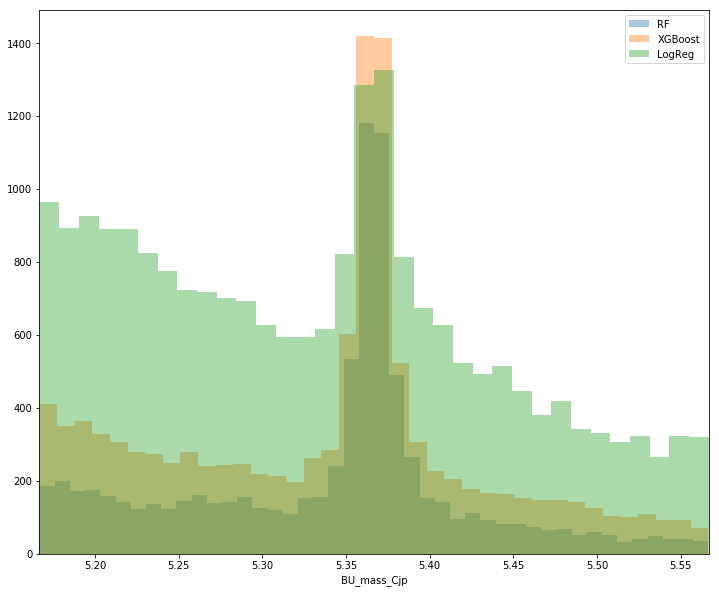

In [43]:
output_cut = 0.8
fig, ax = plt.subplots(figsize=(12,10))

for classifier, prediction in outputs.items():
    final_masses = predict_masses.iloc[prediction > output_cut] 
    print(f'With cut > {output_cut} survived {final_masses.shape[0]} out of {predict_masses.shape[0]} for {classifier}')
    sns.distplot(final_masses[('BU_mass_Cjp')], ax=ax, label = classifier, kde=False, hist=True, norm_hist=False)

ax.set_xlim(sig_window['BU_mass_Cjp'][0], sig_window['BU_mass_Cjp'][1])
# ax.set_title('classifier output')

plt.legend()
# plt.yscale('log')
# plt.ylim(10**(-1))

plt.show()

### **Train vs Test proba plot**

In [44]:
classif = final_gb

In [45]:
Classifier_training_S = np.extract(y_train == 1, classif.predict(dtrain))
Classifier_training_B = np.extract(y_train == 0, classif.predict(dtrain))

Classifier_testing_S = np.extract(y_test == 1, classif.predict(dtest))
Classifier_testing_B = np.extract(y_test == 0, classif.predict(dtest))

In [79]:
Classifier_training_S = np.extract(y_train == 1, classif.predict(X_train))
Classifier_training_B = np.extract(y_train == 0, classif.predict(X_train))

Classifier_testing_S = np.extract(y_test == 1, classif.predict(X_test))
Classifier_testing_B = np.extract(y_test == 0, classif.predict(X_test))

<ErrorbarContainer object of 3 artists>

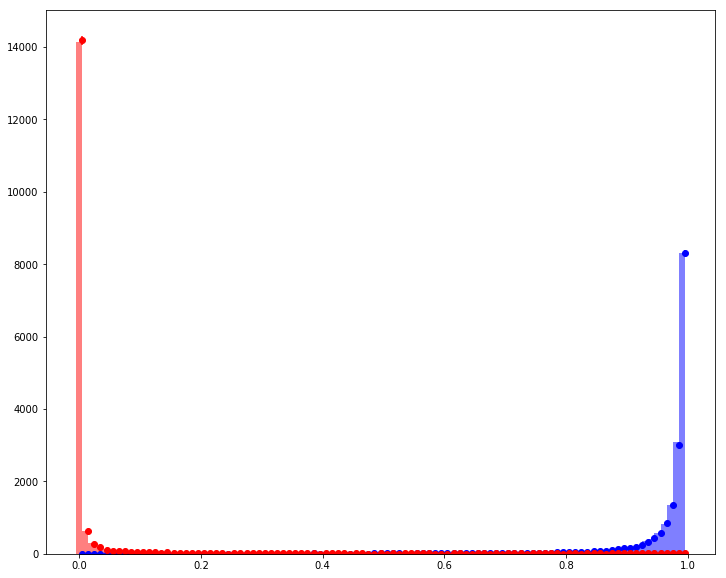

In [46]:
# Get histograms of the classifiers
p_min = 0.; p_max = 1.
Histo_training_S = np.histogram(Classifier_training_S[:Classifier_testing_S.shape[0]],bins=100, range=(p_min,p_max))
Histo_training_B = np.histogram(Classifier_training_B[:Classifier_testing_B.shape[0]],bins=100, range=(p_min,p_max))
Histo_testing_S = np.histogram(Classifier_testing_S,bins=100, range=(p_min,p_max))
Histo_testing_B = np.histogram(Classifier_testing_B,bins=100, range=(p_min,p_max))
 
# Lets get the min/max of the Histograms
AllHistos= [Histo_training_S,Histo_training_B,Histo_testing_S,Histo_testing_B]
h_max = max([histo[0].max() for histo in AllHistos])*1.2
h_min = max([histo[0].min() for histo in AllHistos])
 
# Get the histogram properties (binning, widths, centers)
bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])
 
# To make error bar plots for the data, take the Poisson uncertainty sqrt(N)
ErrorBar_testing_S = numpy.sqrt(Histo_testing_S[0])
ErrorBar_testing_B = numpy.sqrt(Histo_testing_B[0])
 
# Draw objects
f, ax1 = plt.subplots(figsize=(12, 10))

# Draw solid histograms for the training data
ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
ax1.bar(bin_centers-bin_widths/2.,Histo_training_B[0],facecolor='red',linewidth=0,width=bin_widths,label='B (Train)',alpha=0.5)
 
# # Draw error-bar histograms for the testing data
ax1.errorbar(bin_centers, Histo_testing_S[0], yerr=ErrorBar_testing_S, xerr=None, ecolor='blue',c='blue',fmt='o',label='S (Test)')
ax1.errorbar(bin_centers, Histo_testing_B[0], yerr=ErrorBar_testing_B, xerr=None, ecolor='red',c='red',fmt='o',label='B (Test)')

## **Summary**

That's the end! But definitely that's not the end of the story and there is a vast number of exciting things to learn in the ML world. 

By far we got familiar with:

* Jupyter notebooks
* Basic ML concepts
    * Binary classification
    * Preprocessing data
    * CV
    * Overfitting
    * Metrics
* Algorithms
    * Logistic Regression
    * Random Forest
    * XGBoost
* and probably more which I forgot to mention here

<img src="pics/isthis.jpg" alt="drawing" width="800"/>